In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import ast
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Loading in the data sets

In [2]:
credits_df = pd.read_csv('dataset/credits.csv')
titles_df = pd.read_csv('dataset/titles.csv')

## Credits data frame
This data frame shows the actors and directors with their respective movies and shows

In [3]:
credits_df.head()

,person_id,id,name,character,role
0,3748,tm84618,Robert De Niro,Travis Bickle,ACTOR
1,14658,tm84618,Jodie Foster,Iris Steensma,ACTOR
2,7064,tm84618,Albert Brooks,Tom,ACTOR
3,3739,tm84618,Harvey Keitel,Matthew 'Sport' Higgins,ACTOR
4,48933,tm84618,Cybill Shepherd,Betsy,ACTOR


## Titles data frame
This data frame shows the attributes relating to each movie or show with their corresponding imdb scores

In [4]:
titles_df.head()

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,51,['documentation'],['US'],1.0,NaN,NaN,NaN,0.600,NaN
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],NaN,tt0075314,8.2,808582.0,40.965,8.179
2,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],NaN,tt0068473,7.7,107673.0,10.010,7.300
3,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,tt0071853,8.2,534486.0,15.461,7.811
4,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,NaN,150,"['war', 'action']","['GB', 'US']",NaN,tt0061578,7.7,72662.0,20.398,7.600


## Differences between the two data frames
Here we discover that some movies/shows from the titles data frame do not appear in the credits data frame.
These movies and shows will get automatically removed on merge.

In [5]:
# Remove all duplicates
credits_movie_ids = set(credits_df['id'])
titles_movie_ids = set(titles_df['id'])

# Find movie/shows ids that are in titles but not in credits
media_not_in_credits = titles_df[~titles_df['id'].isin(credits_movie_ids)]
print(len(media_not_in_credits))

361


## Group all actors and directors with their respective media
This will give us a list of all actors and directors for each movie and show

In [6]:
# Group by movie id and aggregate the data into lists
grouped_credits_df = credits_df.groupby('id').agg({
    'person_id': lambda x: list(x),
    'name': lambda x: list(x),
    'character': lambda x: list(x),
    'role': lambda x: list(x)
}).reset_index()

# Separate actors and directors into new columns
grouped_credits_df['actor'] = [[name for name, role in zip(names, roles) if role == 'ACTOR'] for names, roles in zip(grouped_credits_df['name'], grouped_credits_df['role'])]
grouped_credits_df['director'] = [[name for name, role in zip(names, roles) if role == 'DIRECTOR'] for names, roles in zip(grouped_credits_df['name'], grouped_credits_df['role'])]

# Create new columns for actor_ids and director_ids
grouped_credits_df['actor_ids'] = [[pid for pid, role in zip(pids, roles) if role == 'ACTOR'] for pids, roles in zip(grouped_credits_df['person_id'], grouped_credits_df['role'])]
grouped_credits_df['director_ids'] = [[pid for pid, role in zip(pids, roles) if role == 'DIRECTOR'] for pids, roles in zip(grouped_credits_df['person_id'], grouped_credits_df['role'])]

# Drop unnecessary columns
grouped_credits_df.drop(['name', 'role', 'person_id'], axis=1, inplace=True)
grouped_credits_df

,id,character,actor,director,actor_ids,director_ids
0,tm1000037,"[Maxi, Karl, Alex, Ante, Jitka, Pankraz, Didie...","[Luna Wedler, Jannis Niewöhner, Milan Peschel,...",[Christian Schwochow],"[251702, 41192, 589580, 191901, 237433, 76618,...",[142171]
1,tm1000147,"[David Carmichael, Jane, Marlon Veidt, Joseph ...","[Guy Pearce, Matilda Anna Ingrid Lutz, Travis ...",[Andrew Baird],"[5080, 159223, 35608, 595294, 9714, 60547, 772...",[954232]
2,tm100015,"[Gordon Jennings, John Rahway, Jack Welles, Ja...","[Idris Elba, Paul Walker, Matt Dillon, Michael...",[John Luessenhop],"[1675, 2673, 13138, 5130, 13145, 13137, 10712,...",[13150]
3,tm1000166,"[Himself, Himself, Herself, Herself, Himself, ...","[Glenn Fredly, Marcello Tahitoe, Andien Aisyah...",[Saron Sakina],"[248002, 1793972, 930514, 1794044, 1793676, 24...",[1793832]
4,tm1000185,"[Monika/Klaudia, Enzo, Ojciec Moniki, Ilona, J...","[Adrianna Chlebicka, Mateusz Banasiuk, Mirosła...",[Filip Zylber],"[1562688, 299215, 106368, 254540, 97525, 20121...",[446979]
...,...,...,...,...,...,...
5484,ts97584,"[Himself - Host, nan]",[Sebastian Perry],[William Mitchell],[1323916],[1324096]
5485,ts9794,[Self - Host],[Jerry Seinfeld],[],[32954],[]
5486,ts98252,"[Skipper (voice), Rico the Penguin (voice), Me...","[Tom McGrath, John DiMaggio, David Schwimmer, ...",[],"[9240, 1950, 9232, 22676, 5664, 8709, 916, 630...",[]
5487,ts98316,[Narrator],[John Hurt],[],[4824],[]


## Merge the two data frames into one data frame

In [7]:
# Merge titles dataframe with grouped credits dataframe
media_df = pd.merge(titles_df, grouped_credits_df, left_on = "id", right_on = "id")

media_df.head()

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,character,actor,director,actor_ids,director_ids
0,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],NaN,tt0075314,8.2,808582.0,40.965,8.179,"[Travis Bickle, Iris Steensma, Tom, Matthew 'S...","[Robert De Niro, Jodie Foster, Albert Brooks, ...",[Martin Scorsese],"[3748, 14658, 7064, 3739, 48933, 32267, 519612...",[3308]
1,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],NaN,tt0068473,7.7,107673.0,10.010,7.300,"[Ed Gentry, Lewis Medlock, Bobby Trippe, Drew ...","[Jon Voight, Burt Reynolds, Ned Beatty, Ronny ...",[John Boorman],"[10103, 13020, 6639, 11224, 24509, 80069, 8403...",[17727]
2,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,tt0071853,8.2,534486.0,15.461,7.811,[King Arthur / Voice of God / Middle Head / Hi...,"[Graham Chapman, John Cleese, Eric Idle, Terry...","[Terry Jones, Terry Gilliam]","[11472, 1549, 11474, 11473, 11475, 11476, 4089...","[11475, 11473]"
3,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,NaN,150,"['war', 'action']","['GB', 'US']",NaN,tt0061578,7.7,72662.0,20.398,7.600,"[Maj. John Reisman, Maj. Gen. Worden, Joseph W...","[Lee Marvin, Ernest Borgnine, Charles Bronson,...",[Robert Aldrich],"[35196, 1050, 16868, 14351, 35197, 35200, 1061...",[1063]
4,ts22164,Monty Python's Flying Circus,SHOW,A British sketch comedy series with the shows ...,1969,TV-14,30,"['comedy', 'european']",['GB'],4.0,tt0063929,8.8,73424.0,17.617,8.306,"[Various, Various / ""It's"" man, Various, Vario...","[Graham Chapman, Michael Palin, Terry Jones, E...",[],"[11472, 11476, 11475, 11474, 11473]",[]


# A look at the data structure

## Summary of all non-derived numerical attributes

In [8]:
media_df.describe()

,release_year,runtime,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
count,5489.000000,5489.000000,1840.000000,5063.000000,5.049000e+03,5487.000000,5317.000000
mean,2016.346147,78.995263,2.227717,6.503279,2.464454e+04,23.417779,6.804581
std,7.010669,38.574447,2.807934,1.155218,9.822354e+04,83.486521,1.138524
min,1954.000000,0.000000,1.000000,1.500000,5.000000e+00,0.600000,1.000000
25%,2016.000000,46.000000,1.000000,5.800000,6.080000e+02,2.902500,6.100000
50%,2018.000000,86.000000,1.000000,6.600000,2.523000e+03,7.095000,6.900000
75%,2020.000000,105.000000,2.000000,7.300000,1.055600e+04,17.262500,7.500000
max,2022.000000,240.000000,42.000000,9.500000,2.294231e+06,2274.044000,10.000000


## Description of the data so far

In [9]:
media_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5489 entries, 0 to 5488
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    5489 non-null   object 
 1   title                 5488 non-null   object 
 2   type                  5489 non-null   object 
 3   description           5481 non-null   object 
 4   release_year          5489 non-null   int64  
 5   age_certification     2990 non-null   object 
 6   runtime               5489 non-null   int64  
 7   genres                5489 non-null   object 
 8   production_countries  5489 non-null   object 
 9   seasons               1840 non-null   float64
 10  imdb_id               5120 non-null   object 
 11  imdb_score            5063 non-null   float64
 12  imdb_votes            5049 non-null   float64
 13  tmdb_popularity       5487 non-null   float64
 14  tmdb_score            5317 non-null   float64
 15  character            

## Ratings count
Here we see how many rows belong to each rating

In [10]:
media_df['imdb_score'].value_counts()

imdb_score
6.5    195
7.1    190
6.7    188
7.4    186
6.3    179
      ... 
1.5      1
9.5      1
9.2      1
1.6      1
1.7      1
Name: count, Length: 78, dtype: int64

# Start of EDAs

## Histograms
Histograms showing number of occurences of each attribute

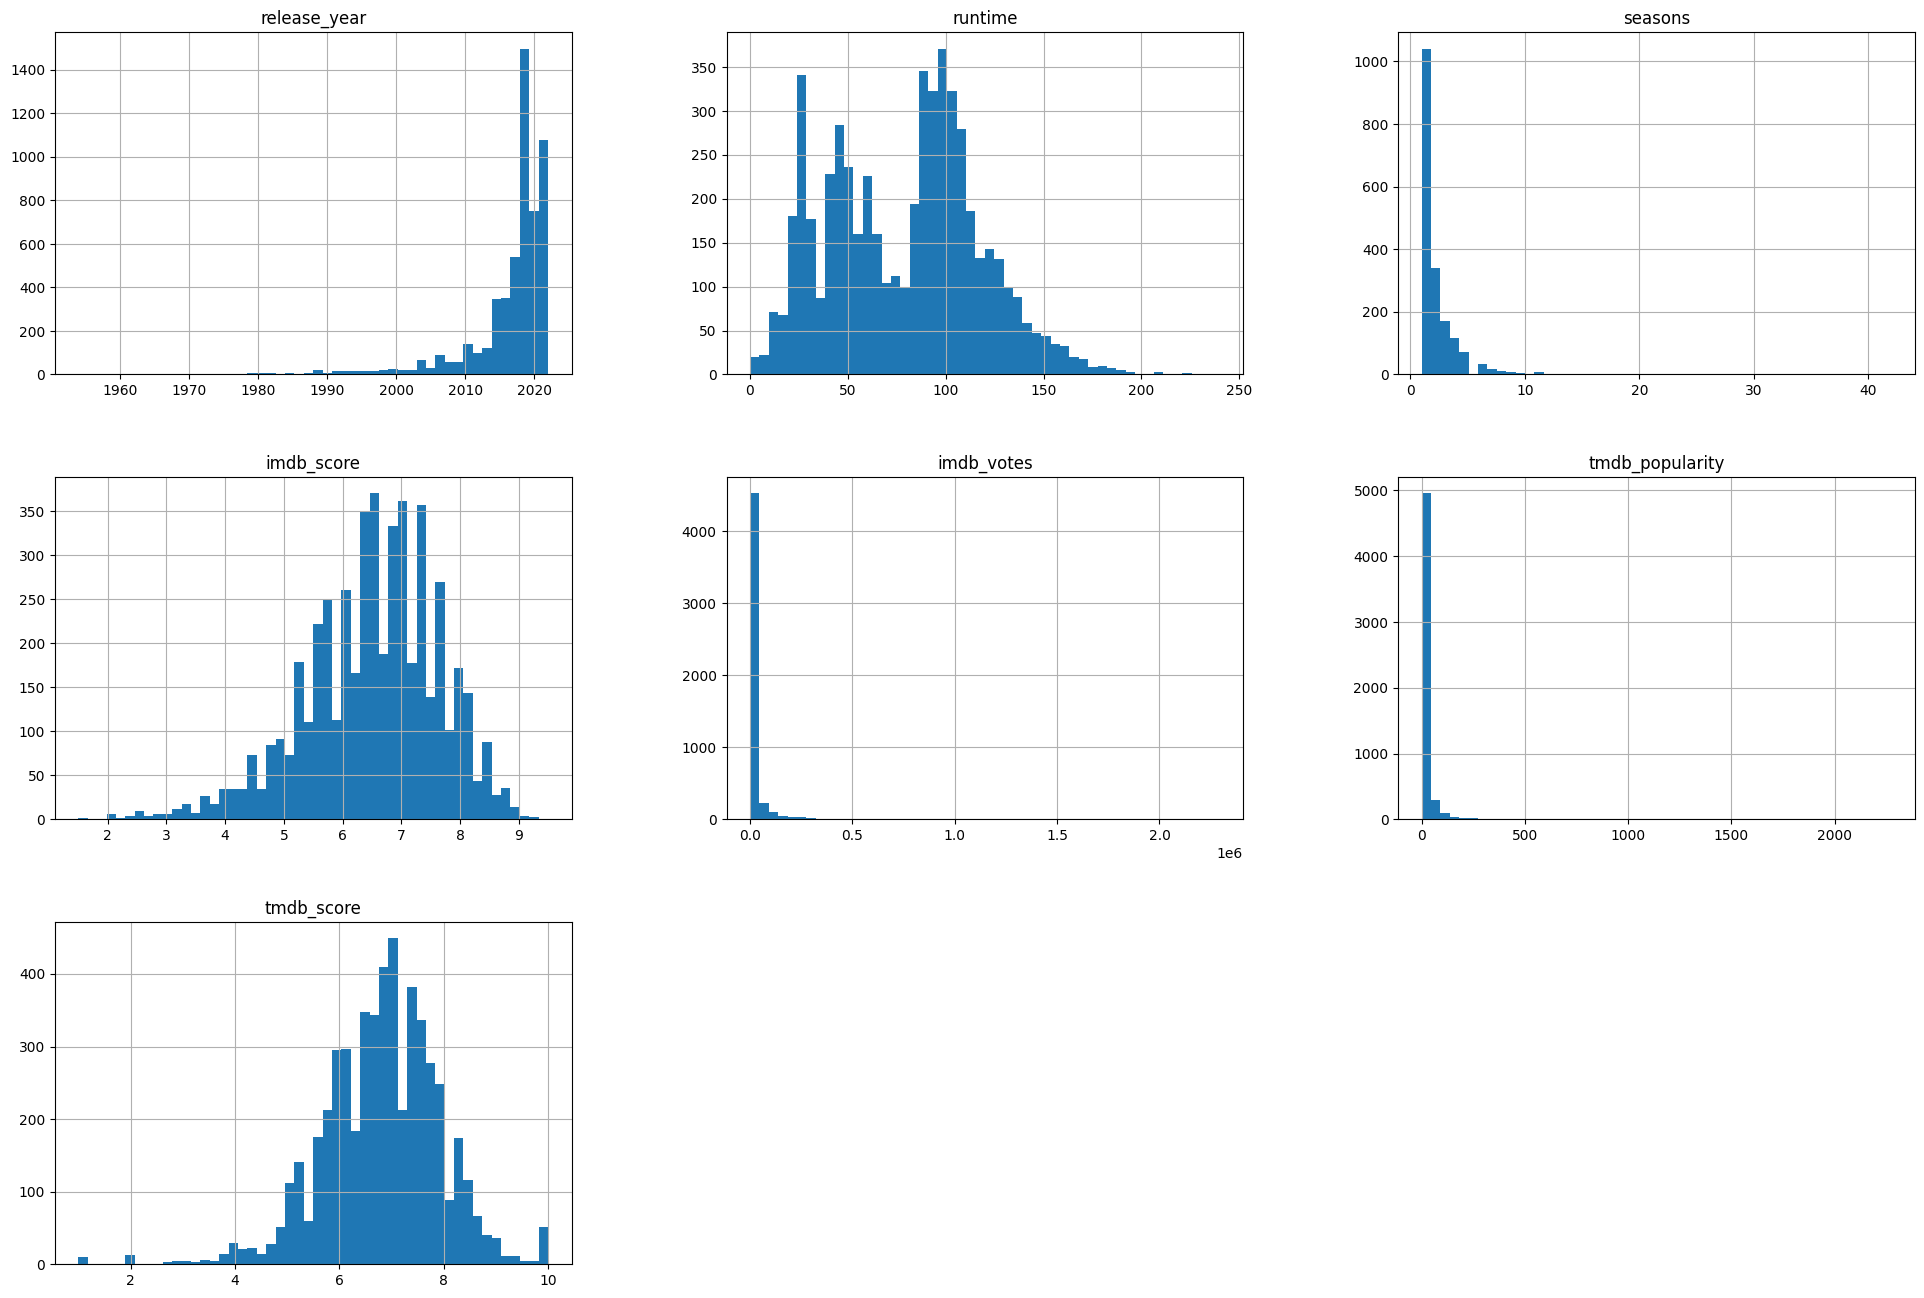

In [11]:
media_df.hist(bins=50, figsize=(24, 16))
plt.show()

## Correlations

### General correlations
Here we see the correlation between the attributes, the only major correlation is imdb_score and tmdb_score. Later on we will explore the correlations between the imdb_score and derived attributes


,release_year,runtime,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
release_year,1.000000,-0.177101,-0.535886,-0.130013,-0.208240,0.046217,0.029133
runtime,-0.177101,1.000000,-0.151898,-0.147415,0.134900,-0.007768,-0.271951
seasons,-0.535886,-0.151898,1.000000,0.104950,0.204067,0.166052,0.048226
imdb_score,-0.130013,-0.147415,0.104950,1.000000,0.197259,0.018180,0.587753
imdb_votes,-0.208240,0.134900,0.204067,0.197259,1.000000,0.207808,0.121751
tmdb_popularity,0.046217,-0.007768,0.166052,0.018180,0.207808,1.000000,0.079296
tmdb_score,0.029133,-0.271951,0.048226,0.587753,0.121751,0.079296,1.000000


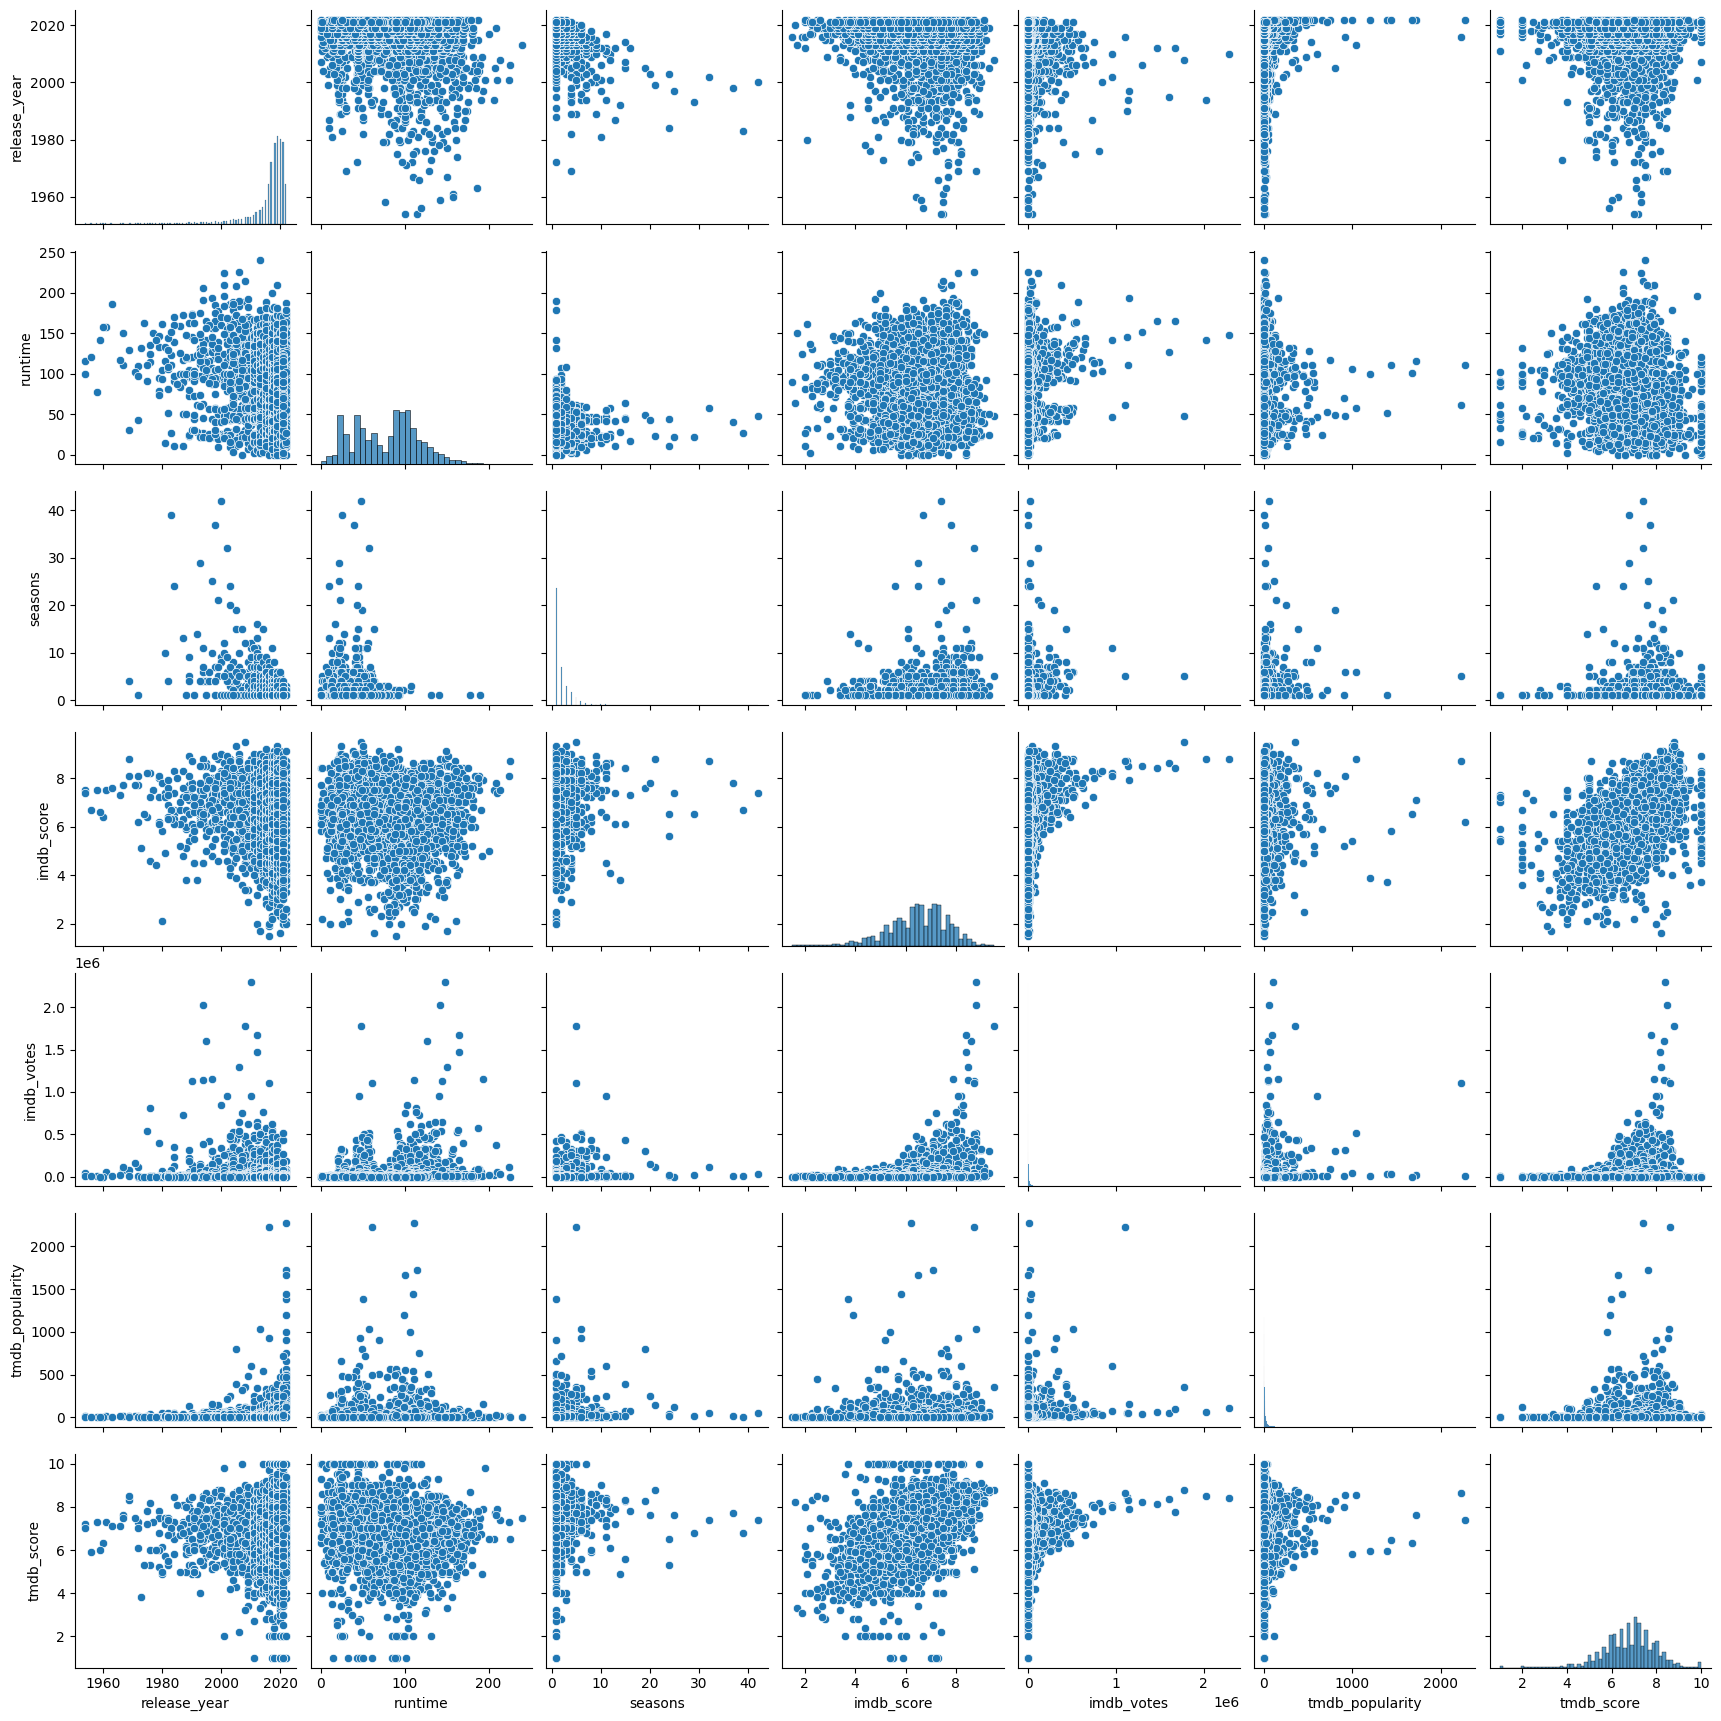

In [12]:
sns.pairplot(media_df)
corr_matrix = media_df.corr(numeric_only=True)
corr_matrix

### Correlations with imdb_score

In [13]:
corr_matrix['imdb_score'].sort_values(ascending=False)

imdb_score         1.000000
tmdb_score         0.587753
imdb_votes         0.197259
seasons            0.104950
tmdb_popularity    0.018180
release_year      -0.130013
runtime           -0.147415
Name: imdb_score, dtype: float64

## Line graph showing correlation of imdb_score vs tmdb_score

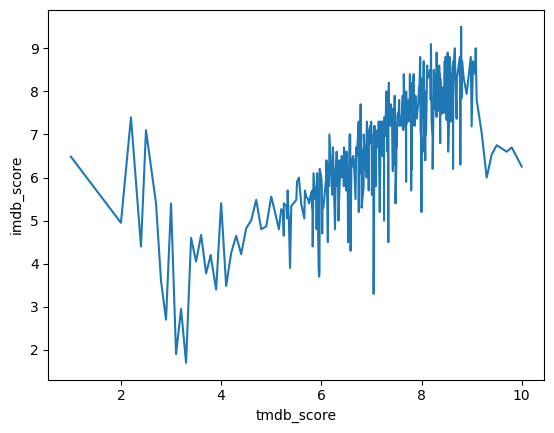

In [14]:
g = sns.lineplot(x="tmdb_score", y="imdb_score", data=media_df, errorbar=None)

## Line graph showing the imdb_score vs tmdb_score over time
This graph demonstrates a similar trend between both scoring platforms over time. However, in terms of correlation, we see many discrepencies at certain periods of time

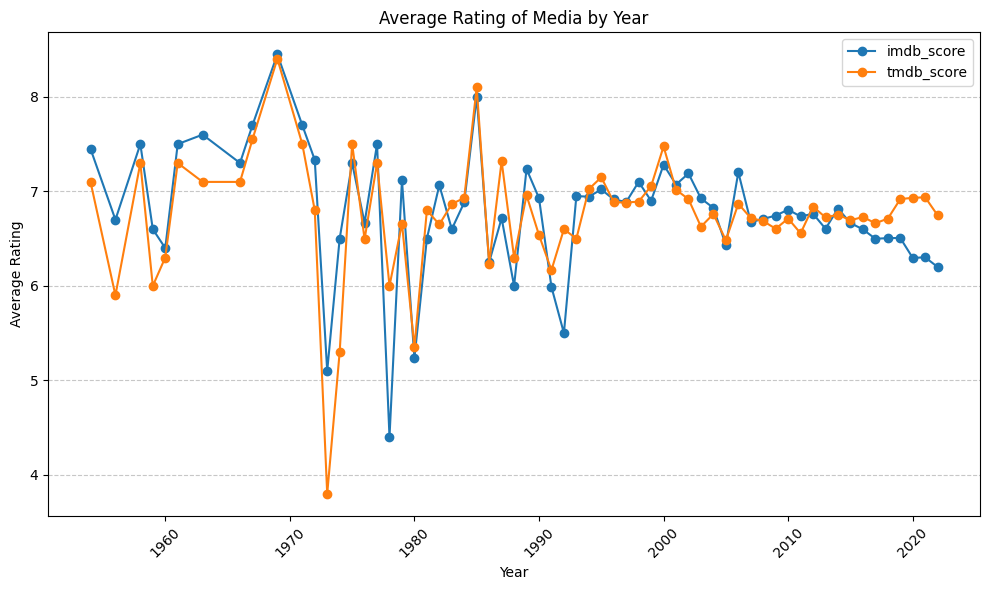

In [15]:
# Rating of movies and shows over time
score_columns = ['imdb_score','tmdb_score']
avg_media_ratings = media_df.groupby('release_year')[score_columns].mean()

def plot_avg_rating_by_year(avg_ratings):
    plt.figure(figsize=(10, 6))
    
    for column in score_columns:
        plt.plot(avg_ratings.index, avg_ratings[column], marker='o', linestyle='-', label=column)
    
    # Plot line graphs
    plt.title('Average Rating of Media by Year')
    plt.xlabel('Year')
    plt.ylabel('Average Rating')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

plot_avg_rating_by_year(avg_media_ratings)

## Scatter plot showing correlation of imdb_score vs imdb_votes
Generally speaking the higher the rating the higher the vote count

Text(0, 0.5, 'imdb_votes')

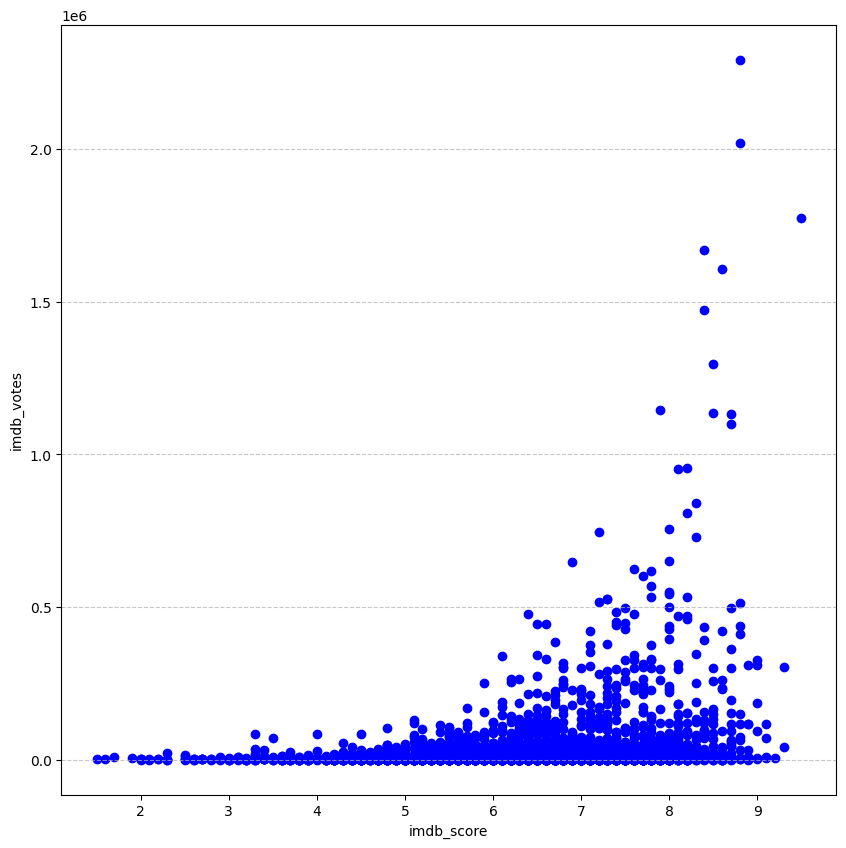

In [16]:
X = media_df["imdb_score"]
y = media_df["imdb_votes"]

fig, pl = plt.subplots(figsize=(10, 10))
pl.scatter(X, y, color = 'b')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlabel("imdb_score")
plt.ylabel("imdb_votes")

# Correlation between imdb_score with genre average imdb score and filmmakers average cumulative media imdb scores

## Cumulative average attributes of film makers
Here we add two new columns that refer to the cumulative average imdb scores of the actors and directors for each piece of media as well as hot encoding the genres and adding an average genre score


In [17]:
# Merge titles dataframe with credits dataframe
combined_df = pd.merge(titles_df, credits_df, left_on = "id", right_on = "id")

actor_df=combined_df[combined_df['role']=='ACTOR']
director_df=combined_df[combined_df['role']=='DIRECTOR']

# Calculate average scores for actors and directors
actors_avg_scores = actor_df.groupby('person_id')['imdb_score'].mean().reset_index()
directors_avg_scores = director_df.groupby('person_id')['imdb_score'].mean().reset_index()

# Function to calculate cumulative average score
def calculate_cumulative_avg(person_ids, avg_scores_df):
    scores = avg_scores_df[avg_scores_df['person_id'].isin(person_ids)]['imdb_score']

    if len(scores) == 0:
        return None
    return scores.mean()

# Apply the function to each row in 'media_df' and create new columns
media_df['cumulative_avg_actor_score'] = media_df['actor_ids'].apply(lambda x: calculate_cumulative_avg(x, actors_avg_scores))
media_df['cumulative_avg_director_score'] = media_df['director_ids'].apply(lambda x: calculate_cumulative_avg(x, directors_avg_scores))

media_df.head()

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,...,imdb_votes,tmdb_popularity,tmdb_score,character,actor,director,actor_ids,director_ids,cumulative_avg_actor_score,cumulative_avg_director_score
0,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],NaN,...,808582.0,40.965,8.179,"[Travis Bickle, Iris Steensma, Tom, Matthew 'S...","[Robert De Niro, Jodie Foster, Albert Brooks, ...",[Martin Scorsese],"[3748, 14658, 7064, 3739, 48933, 32267, 519612...",[3308],7.983333,8.16
1,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],NaN,...,107673.0,10.010,7.300,"[Ed Gentry, Lewis Medlock, Bobby Trippe, Drew ...","[Jon Voight, Burt Reynolds, Ned Beatty, Ronny ...",[John Boorman],"[10103, 13020, 6639, 11224, 24509, 80069, 8403...",[17727],7.521970,7.70
2,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,...,534486.0,15.461,7.811,[King Arthur / Voice of God / Middle Head / Hi...,"[Graham Chapman, John Cleese, Eric Idle, Terry...","[Terry Jones, Terry Gilliam]","[11472, 1549, 11474, 11473, 11475, 11476, 4089...","[11475, 11473]",8.142933,8.15
3,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,NaN,150,"['war', 'action']","['GB', 'US']",NaN,...,72662.0,20.398,7.600,"[Maj. John Reisman, Maj. Gen. Worden, Joseph W...","[Lee Marvin, Ernest Borgnine, Charles Bronson,...",[Robert Aldrich],"[35196, 1050, 16868, 14351, 35197, 35200, 1061...",[1063],7.686111,7.70
4,ts22164,Monty Python's Flying Circus,SHOW,A British sketch comedy series with the shows ...,1969,TV-14,30,"['comedy', 'european']",['GB'],4.0,...,73424.0,17.617,8.306,"[Various, Various / ""It's"" man, Various, Vario...","[Graham Chapman, Michael Palin, Terry Jones, E...",[],"[11472, 11476, 11475, 11474, 11473]",[],7.952042,NaN


## Hot encoding genres
Hot encoded all the genres with binary values

In [18]:
genres_list = []

# Use ast.literal_eval to store all genres into a list
for x in media_df['genres']:
    y = ast.literal_eval(x)
    genres_list.extend(y)

# Remove duplicates
genres_set = list(set(genres_list))

# Create a DataFrame of genres with binary values (0 or 1)
genres_df = media_df['genres'].apply(lambda x: pd.Series([1 if genre in ast.literal_eval(x) else 0 for genre in genres_set], index=genres_set))

# Concatenate the new DataFrame with the original one
media_df = pd.concat([media_df, genres_df], axis=1)

media_df = media_df.drop('genres', axis=1)

media_df = media_df.drop_duplicates(subset='id')
media_df.reset_index(drop=True, inplace=True)

media_df.head()

,id,title,type,description,release_year,age_certification,runtime,production_countries,seasons,imdb_id,...,music,comedy,war,sport,family,european,action,crime,thriller,fantasy
0,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,['US'],NaN,tt0075314,...,0,0,0,0,0,0,0,1,0,0
1,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,['US'],NaN,tt0068473,...,0,0,0,0,0,1,1,0,1,0
2,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,['GB'],NaN,tt0071853,...,0,1,0,0,0,0,1,0,0,1
3,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,NaN,150,"['GB', 'US']",NaN,tt0061578,...,0,0,1,0,0,0,1,0,0,0
4,ts22164,Monty Python's Flying Circus,SHOW,A British sketch comedy series with the shows ...,1969,TV-14,30,['GB'],4.0,tt0063929,...,0,1,0,0,0,1,0,0,0,0


## Calculating the average imdb score for each genre

In [19]:
# Calculate the average IMDb score for each genre
average_scores_by_genre = {}
for genre in genres_set:
    genre_columns = [col for col in media_df.columns if genre in col]
    average_scores_by_genre[genre] = media_df[media_df[genre_columns].any(axis=1)]['imdb_score'].mean()

# Convert the result into a DataFrame
average_scores_df = pd.DataFrame(list(average_scores_by_genre.items()), columns=['Genre', 'Average IMDb Score'])

# Sort genres by average score in descending order
average_scores_df = average_scores_df.sort_values(by='Average IMDb Score', ascending=False)

## Getting the mean of the genres associated with each film

In [20]:
media_df['cumulative_avg_genre_imdb'] = 0

# Lowercase the genre names in media_df columns
media_df.columns = [col.lower() for col in media_df.columns]

#iterate through rows
for index, row in media_df.iterrows():
    score = 0
    numCount = 0
    
    #iterate through the new columns that were hot encoded
    for genre in media_df.columns[20:]:

        #find the mean for that genre and add it to its average imdb score
        if row[genre] == 1:
            numCount += 1
            genre_name = genre.split('_')[-1].lower()  # Extract genre name and lowercase
            
            if genre_name in average_scores_df['Genre'].str.lower().values:
                score += average_scores_df.loc[average_scores_df['Genre'].str.lower() == genre_name, 'Average IMDb Score'].values[0]
    
    if numCount > 0:
        score /= numCount

    media_df.at[index, 'cumulative_avg_genre_imdb'] = score

media_df.head()

C:\Users\chapl\AppData\Local\Temp\ipykernel_22892\779610399.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '6.635201686699313' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  media_df.at[index, 'cumulative_avg_genre_imdb'] = score


,id,title,type,description,release_year,age_certification,runtime,production_countries,seasons,imdb_id,...,comedy,war,sport,family,european,action,crime,thriller,fantasy,cumulative_avg_genre_imdb
0,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,['US'],NaN,tt0075314,...,0,0,0,0,0,0,1,0,0,6.635202
1,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,['US'],NaN,tt0068473,...,0,0,0,0,1,1,0,1,0,6.480488
2,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,['GB'],NaN,tt0071853,...,1,0,0,0,0,1,0,0,1,6.455812
3,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,NaN,150,"['GB', 'US']",NaN,tt0061578,...,0,1,0,0,0,1,0,0,0,6.741455
4,ts22164,Monty Python's Flying Circus,SHOW,A British sketch comedy series with the shows ...,1969,TV-14,30,['GB'],4.0,tt0063929,...,1,0,0,0,1,0,0,0,0,6.447009


## New correlation with the necessary columns
Removed the genres hot encoding so they dont interfere with the correlation

,release_year,runtime,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,cumulative_avg_actor_score,cumulative_avg_director_score,cumulative_avg_genre_imdb
release_year,1.000000,-0.177101,-0.535886,-0.130013,-0.208240,0.046217,0.029133,-0.133388,-0.115726,0.010190
runtime,-0.177101,1.000000,-0.151898,-0.147415,0.134900,-0.007768,-0.271951,-0.123253,-0.056355,0.052989
seasons,-0.535886,-0.151898,1.000000,0.104950,0.204067,0.166052,0.048226,0.063692,-0.040094,-0.014607
imdb_score,-0.130013,-0.147415,0.104950,1.000000,0.197259,0.018180,0.587753,0.940292,0.933886,0.222583
imdb_votes,-0.208240,0.134900,0.204067,0.197259,1.000000,0.207808,0.121751,0.180997,0.166000,-0.031504
tmdb_popularity,0.046217,-0.007768,0.166052,0.018180,0.207808,1.000000,0.079296,0.008737,-0.037726,-0.004894
tmdb_score,0.029133,-0.271951,0.048226,0.587753,0.121751,0.079296,1.000000,0.529032,0.581226,0.040321
cumulative_avg_actor_score,-0.133388,-0.123253,0.063692,0.940292,0.180997,0.008737,0.529032,1.000000,0.904946,0.112443
cumulative_avg_director_score,-0.115726,-0.056355,-0.040094,0.933886,0.166000,-0.037726,0.581226,0.904946,1.000000,0.170165
cumulative_avg_genre_imdb,0.010190,0.052989,-0.014607,0.222583,-0.031504,-0.004894,0.040321,0.112443,0.170165,1.000000


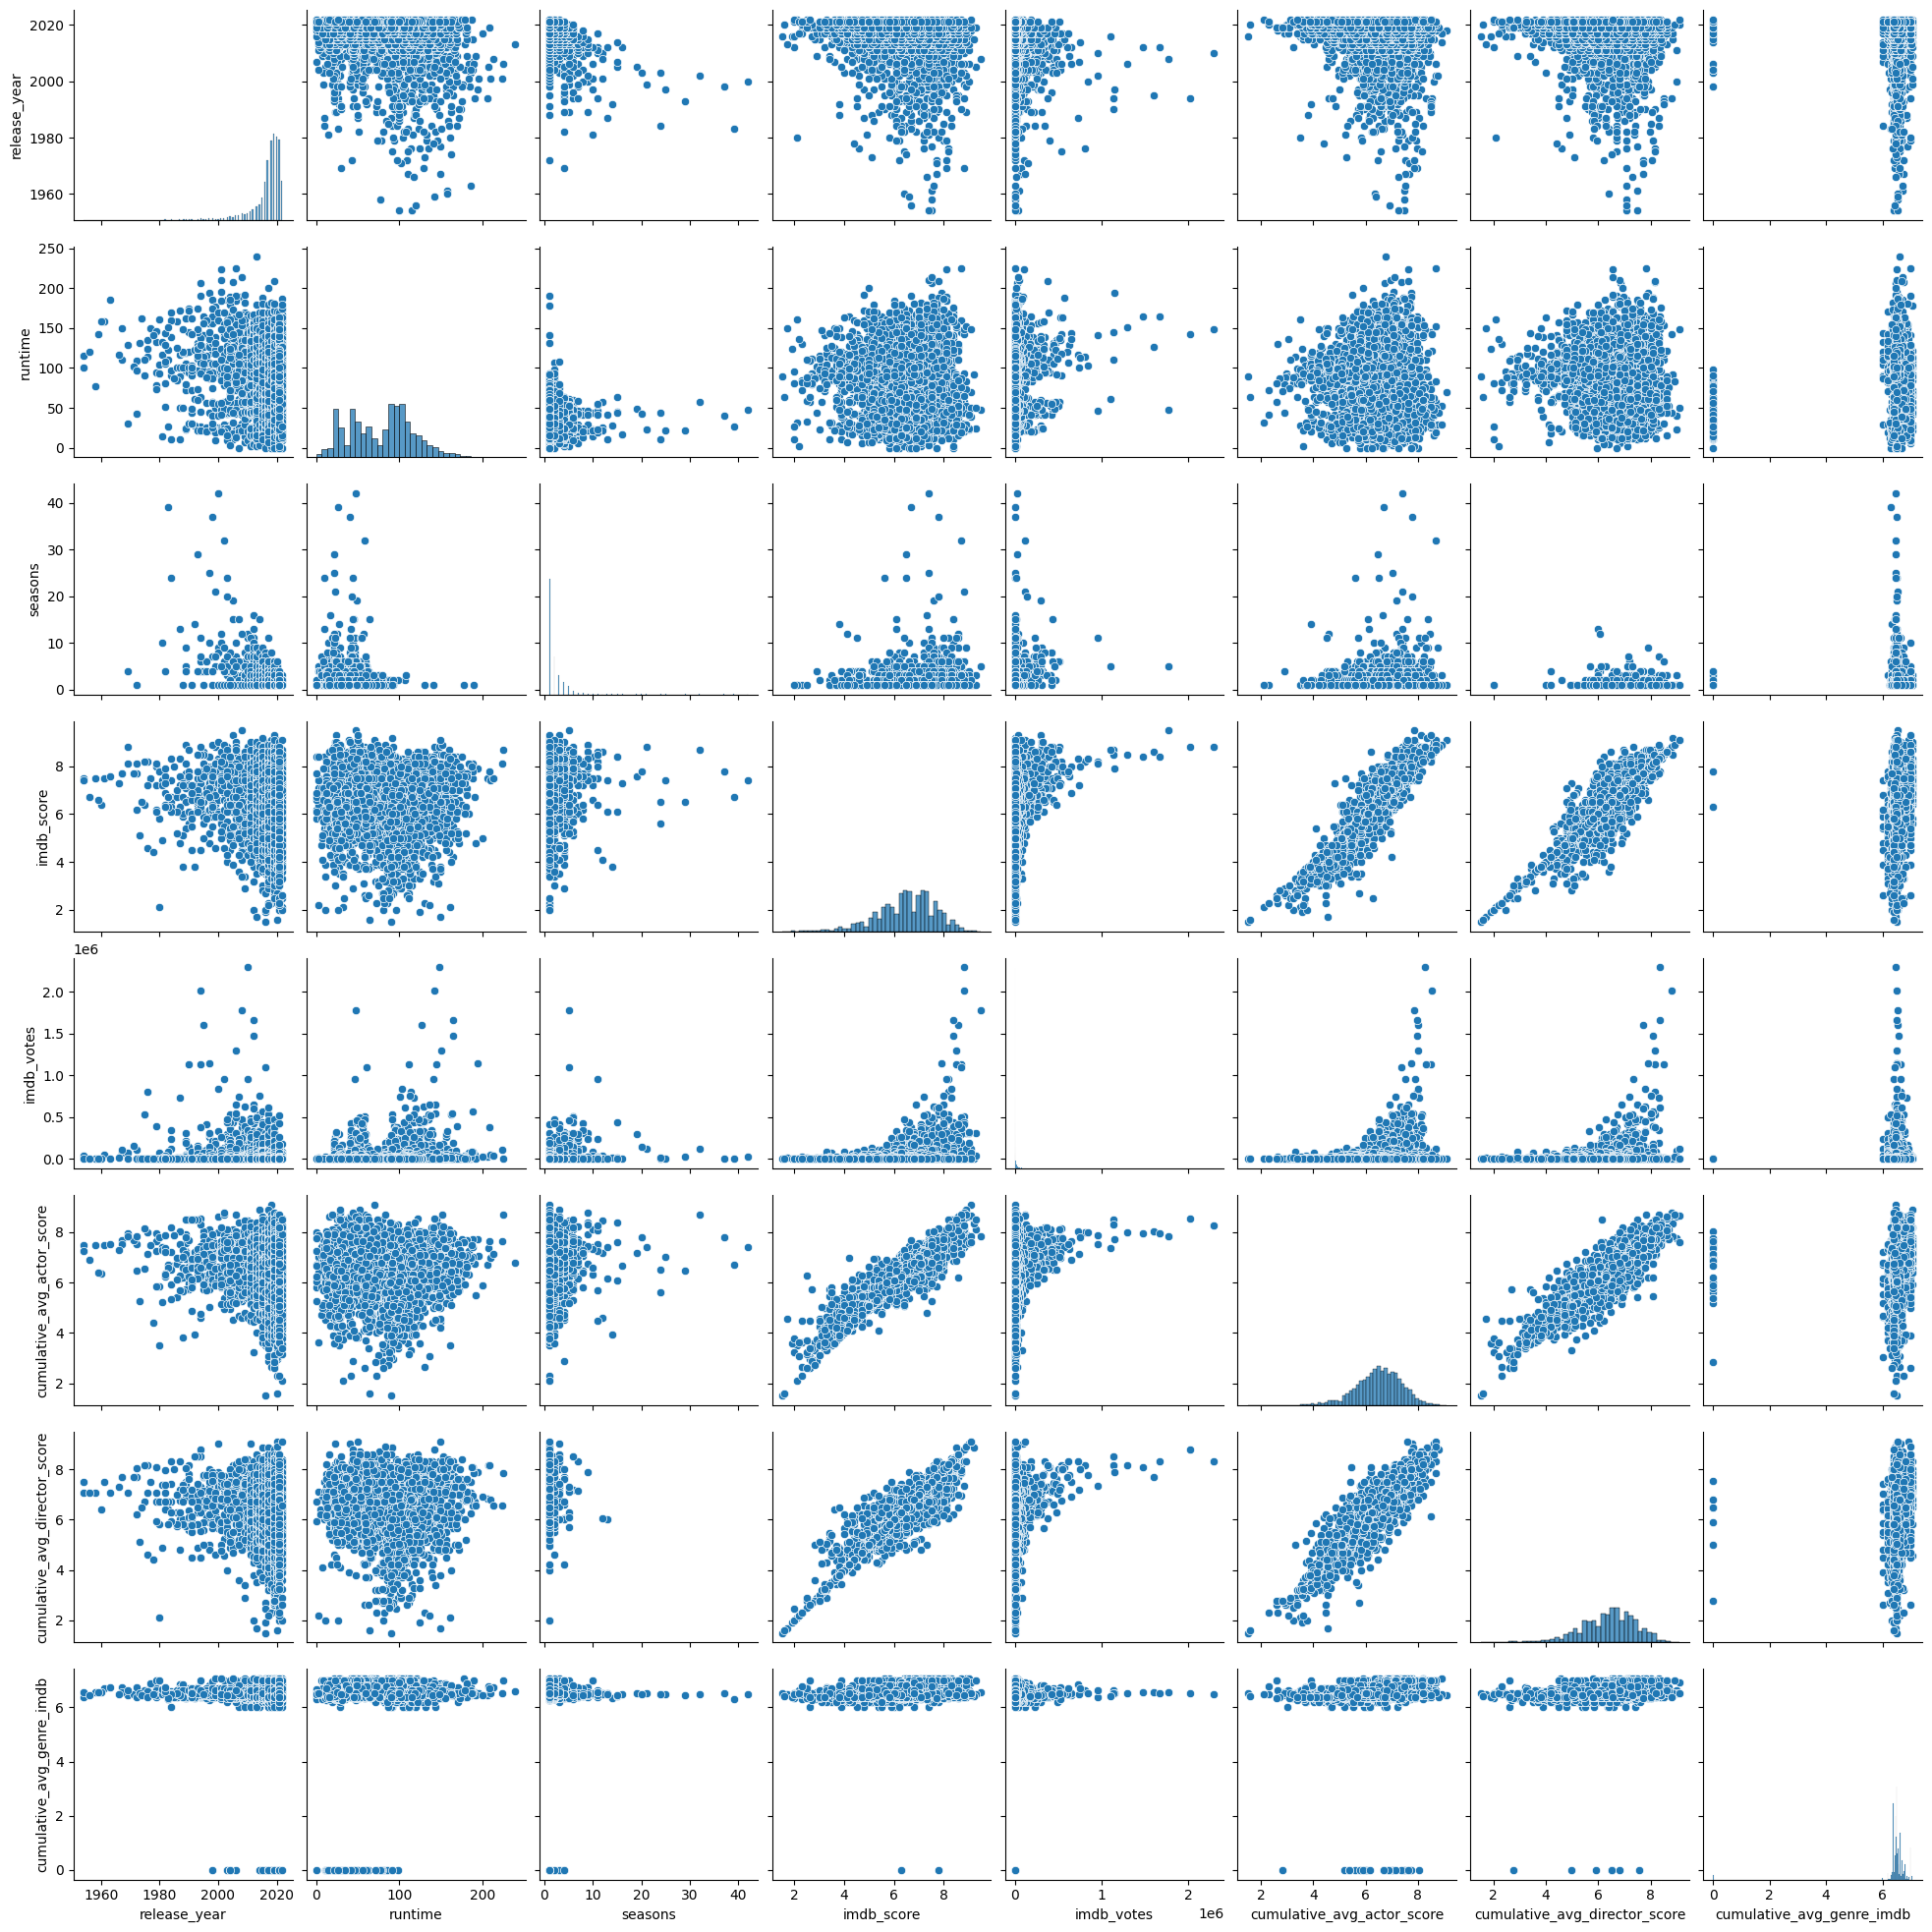

In [21]:
# List of columns we want to include in the EDAs and correlation
media_include=['release_year', 'age_certification', 'runtime', 'seasons', 'imdb_score',
       'imdb_votes', 'cumulative_avg_actor_score',
       'cumulative_avg_director_score', 'cumulative_avg_genre_imdb']

media_subset=media_df[media_include]

sns.pairplot(media_subset)

# List we want to exlude from the EDAs and correlation
columns_to_exclude = ['crime', 'history', 'drama', 'fantasy',
       'documentation', 'animation', 'reality', 'music', 'comedy', 'scifi',
       'war', 'horror', 'family', 'western', 'romance', 'thriller', 'sport',
       'european', 'action']

# Creating correlation matrix
corr_matrix_new = media_df.corr(numeric_only=True)
corr_matrix_new = corr_matrix_new.drop(columns=columns_to_exclude, index=columns_to_exclude)
corr_matrix_new

# Data Cleaning

Remove all unnecessary data based on correlations gathered from previous observations and prepare the data for preprocessing.

In [22]:
# Data cleaning
media_df = media_df.drop(columns=['imdb_id','tmdb_popularity','tmdb_score','character'], axis=1)
media_df.dropna(subset=['title','imdb_score','imdb_votes'], inplace=True)
media_df['seasons']=media_df['seasons'].fillna(0)
media_df=media_df.dropna()

media_df.reset_index().head()

,index,id,title,type,description,release_year,age_certification,runtime,production_countries,seasons,...,comedy,war,sport,family,european,action,crime,thriller,fantasy,cumulative_avg_genre_imdb
0,0,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,['US'],0.0,...,0,0,0,0,0,0,1,0,0,6.635202
1,1,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,['US'],0.0,...,0,0,0,0,1,1,0,1,0,6.480488
2,2,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,['GB'],0.0,...,1,0,0,0,0,1,0,0,1,6.455812
3,5,tm70993,Life of Brian,MOVIE,"Brian Cohen is an average young Jewish man, bu...",1979,R,94,['GB'],0.0,...,1,0,0,0,0,0,0,0,0,6.386289
4,6,tm14873,Dirty Harry,MOVIE,When a madman dubbed 'Scorpio' terrorizes San ...,1971,R,102,['US'],0.0,...,0,0,0,0,0,1,1,1,0,6.477822


In [23]:
# Removing all rows that arents being used to predict the outcome

media_df=media_df.drop(columns='actor')
media_df=media_df.drop(columns='actor_ids')
media_df=media_df.drop(columns='director')
media_df=media_df.drop(columns='director_ids')
media_df=media_df.drop(columns='production_countries')
media_df=media_df.drop(columns='description')

media_df=media_df.drop(columns='type')
media_df=media_df.drop(columns='id')
#media_df=media_df.drop(columns='age_certification')
media_df=media_df.drop(columns="cumulative_avg_genre_imdb")
newMedia= media_df.copy()
newMedia.drop(columns='age_certification')
media_df=media_df.drop(columns='title')

media_df

,release_year,age_certification,runtime,seasons,imdb_score,imdb_votes,cumulative_avg_actor_score,cumulative_avg_director_score,documentation,horror,...,music,comedy,war,sport,family,european,action,crime,thriller,fantasy
0,1976,R,114,0.0,8.2,808582.0,7.983333,8.160000,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1972,R,109,0.0,7.7,107673.0,7.521970,7.700000,0,0,...,0,0,0,0,0,1,1,0,1,0
2,1975,PG,91,0.0,8.2,534486.0,8.142933,8.150000,0,0,...,0,1,0,0,0,0,1,0,0,1
5,1979,R,94,0.0,8.0,395024.0,7.937238,8.100000,0,0,...,0,1,0,0,0,0,0,0,0,0
6,1971,R,102,0.0,7.7,155051.0,7.681287,7.700000,0,0,...,0,0,0,0,0,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5417,2022,PG-13,58,0.0,6.1,378.0,6.100000,6.100000,0,0,...,1,0,0,0,0,0,0,0,0,0
5449,2021,R,113,0.0,5.4,262.0,5.400000,6.933333,1,0,...,0,0,0,0,0,0,0,0,0,0
5451,2021,R,96,0.0,6.0,10515.0,6.126825,6.000000,0,0,...,0,1,0,0,0,0,0,0,0,0
5466,2021,TV-MA,49,1.0,8.3,2346.0,8.172727,8.300000,1,0,...,0,0,0,0,0,0,0,0,0,0


# Preprocessing

In [24]:
#Code From Sample provided by Professor Ruba Al Omari on Eclass
# Create the cat and num columns
num_cols = media_df.select_dtypes(include='number').columns.to_list()
cat_cols = media_df.select_dtypes(exclude='number').columns.to_list()

# Exclude the target from numerical columns
num_cols.remove("imdb_score")

# Create pipelines for numeric and categorical columns
num_pipeline = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())
cat_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder())

# Use ColumnTransformer to set the estimators and transformations
preprocessing = ColumnTransformer([('num', num_pipeline, num_cols),
                                   ('cat', cat_pipeline, cat_cols)],
                                    remainder='passthrough'
                                 )

In [25]:
preprocessing

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['release_year', 'runtime', 'seasons',
                                  'imdb_votes', 'cumulative_avg_actor_score',
                                  'cumulative_avg_director_score',
                                  'documentation', 'horror', 'animation',
                                  'scifi', 'drama', 'western', 'reality',
                                  'romance', 'history', 'music', 'comedy',
                                  'war', 'sport', 'family', 'european',
                                  'action', 'crime', 'thriller', 'fantasy']),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder())]),
                                 ['age_certification'])])

## Applying the preprocessing

In [26]:
#Code From Sample provided by Professor Ruba Al Omari on Eclass
# Apply the preprocessing pipeline on the dataset
media_prepared = preprocessing.fit_transform(media_df)

feature_names=preprocessing.get_feature_names_out()
media_prepared = pd.DataFrame(data=media_prepared, columns=feature_names)
 
media_prepared.head()

,num__release_year,num__runtime,num__seasons,num__imdb_votes,num__cumulative_avg_actor_score,num__cumulative_avg_director_score,num__documentation,num__horror,num__animation,num__scifi,...,cat__age_certification_PG,cat__age_certification_PG-13,cat__age_certification_R,cat__age_certification_TV-14,cat__age_certification_TV-G,cat__age_certification_TV-MA,cat__age_certification_TV-PG,cat__age_certification_TV-Y,cat__age_certification_TV-Y7,remainder__imdb_score
0,-5.080088,0.588637,-0.403952,5.026390,1.633843,1.574847,-0.353058,-0.310235,-0.331485,-0.350823,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,8.2
1,-5.600641,0.447054,-0.403952,0.372909,1.114336,1.132352,-0.353058,-0.310235,-0.331485,-0.350823,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,7.7
2,-5.210227,-0.062646,-0.403952,3.206610,1.813557,1.565227,-0.353058,-0.310235,-0.331485,-0.350823,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.2
3,-4.689674,0.022304,-0.403952,2.280693,1.581939,1.517130,-0.353058,-0.310235,-0.331485,-0.350823,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
4,-5.730779,0.248837,-0.403952,0.687462,1.293731,1.132352,-0.353058,-0.310235,-0.331485,-0.350823,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,7.7


## Split the data into testing and training sets

In [27]:
#Code From Sample provided by Professor Ruba Al Omari on Eclass
X = media_prepared.drop("remainder__imdb_score", axis=1)
y = media_prepared['remainder__imdb_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1284, 36) (1284,) (322, 36) (322,)


# AI Algorithms
Linear Regression, Ridge Regression and Lasso Regression

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso

## The Linear Regression Algorithm

In [29]:
# Initialize a Linear Regression model
lr_model = LinearRegression()

# Fit the model on the training data
lr_model.fit(X_train, y_train)

LinearRegression()

In [30]:
#Code From Sample provided by Professor Ruba Al Omari on Eclass
# Predict using the trained Linear Regression model on the test data
lr_y_predict = lr_model.predict(X_test)

# Calculate Mean Squared Error (MSE) between the true target values (y_test) and the predicted values (lr_y_predict)
lr_mse = mse(y_test, lr_y_predict)
linear_reg_r2 = r2(y_test,lr_y_predict)
print(f"Linear Regression MSE:{lr_mse}")
print(f'Ridge Regression R2: {linear_reg_r2}')

Linear Regression MSE:0.07132332942715375
Ridge Regression R2: 0.9432125561469084


## Ridge Regression Algorithm

In [31]:
#Code From Sample provided by Professor Ruba Al Omari on Eclass
# Initialize Ridge Regression model with regularization parameter alpha=1
ridge_model = Ridge(alpha=1)

# Fit Ridge Regression model on the training data
ridge_model.fit(X_train, y_train)

# Predict using the Ridge Regression model on the test data
Ridge_y_predict = ridge_model.predict(X_test)

# Calculate Mean Squared Error (MSE) between the true target values (y_test) and the predicted values (Ridge_y_predict)
ridge_mse = mse(y_test, Ridge_y_predict)

ridge_reg_r2 = r2(y_test, Ridge_y_predict)
print(f'Ridge Regression MSE: {ridge_mse}')
print(f'Ridge Regression R2: {ridge_reg_r2}')


Ridge Regression MSE: 0.07142584107682474
Ridge Regression R2: 0.9431309366460138


## Lasso Regression Algorithm

In [32]:
#Code From Sample provided by Professor Ruba Al Omari on Eclass
# Initialize Lasso Regression model with regularization parameter alpha=1
lasso_model = Lasso(alpha=1)

# Fit Lasso Regression model on the training data
lasso_model.fit(X_train, y_train)

# Predict using the Lasso Regression model on the test data
Lasso_y_predict = lasso_model.predict(X_test)

# Calculate Mean Squared Error (MSE) between the true target values (y_test) and the predicted values (Lasso_y_predict)
lasso_mse = mse(y_test, Lasso_y_predict)

lasso_reg_r2 = r2(y_test, Lasso_y_predict)

print(f'Lasso Regression MSE: {lasso_mse}')
print(f'Lasso Regression R2: {lasso_reg_r2}')

Lasso Regression MSE: 1.0925579792946976
Lasso Regression R2: 0.13010826326029445


In [33]:
# Perform cross-validation on the Linear Regression model using 5-fold cross-validation
scores = cross_val_score(lr_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

print("Linear Regression Scores: ",scores)

Linear Regression Scores:  [-0.10254116 -0.10356265 -0.08708692 -0.08751274 -0.08875856]


In [43]:
# Take the negative value to get the mean squared error
mean_score = -scores.mean()  

print(f'Cross-Validation Mean Score: {mean_score}')

Cross-Validation Mean Score: 0.0938924055297641


## Comparing the MSE for all the algorithms

In [35]:
print(f'Linear Regression MSE: {lr_mse}')
print(f'Cross-Validation Mean Score: {mean_score}')
print(f'Ridge Regression MSE: {ridge_mse}')
print(f'Lasso Regression MSE: {lasso_mse}')

Linear Regression MSE: 0.07132332942715375
Cross-Validation Mean Score: 0.0938924055297641
Ridge Regression MSE: 0.07142584107682474
Lasso Regression MSE: 1.0925579792946976


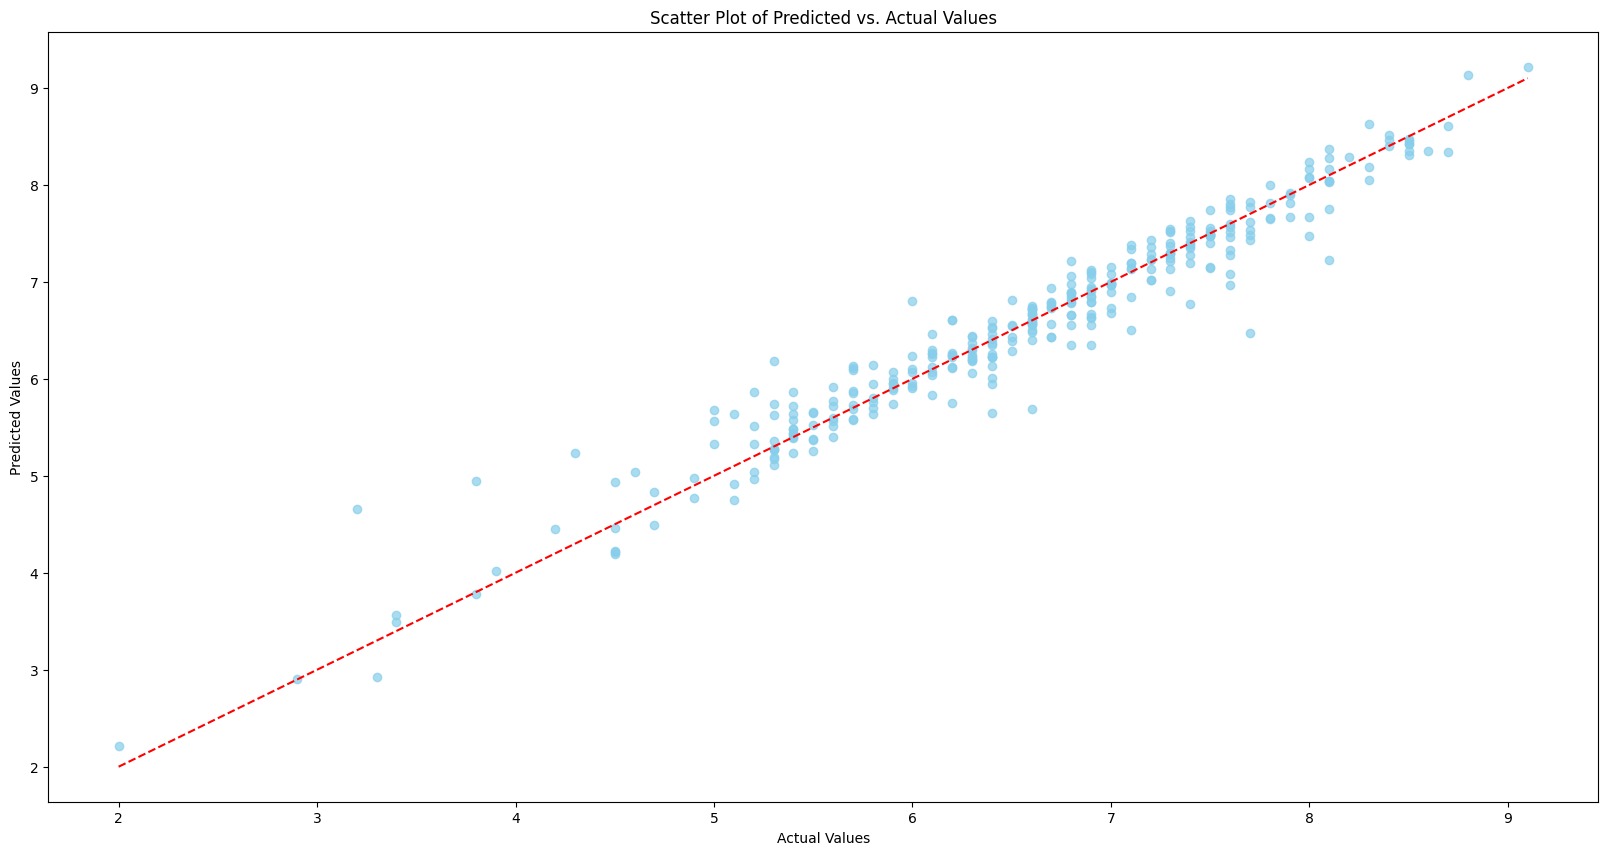

In [36]:
# Assuming 'lr_model' is your best performing trained linear regression model
plt.figure(figsize=(20,10))
plt.scatter(y_test, lr_y_predict, color='skyblue', alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot of Predicted vs. Actual Values')

plt.show()


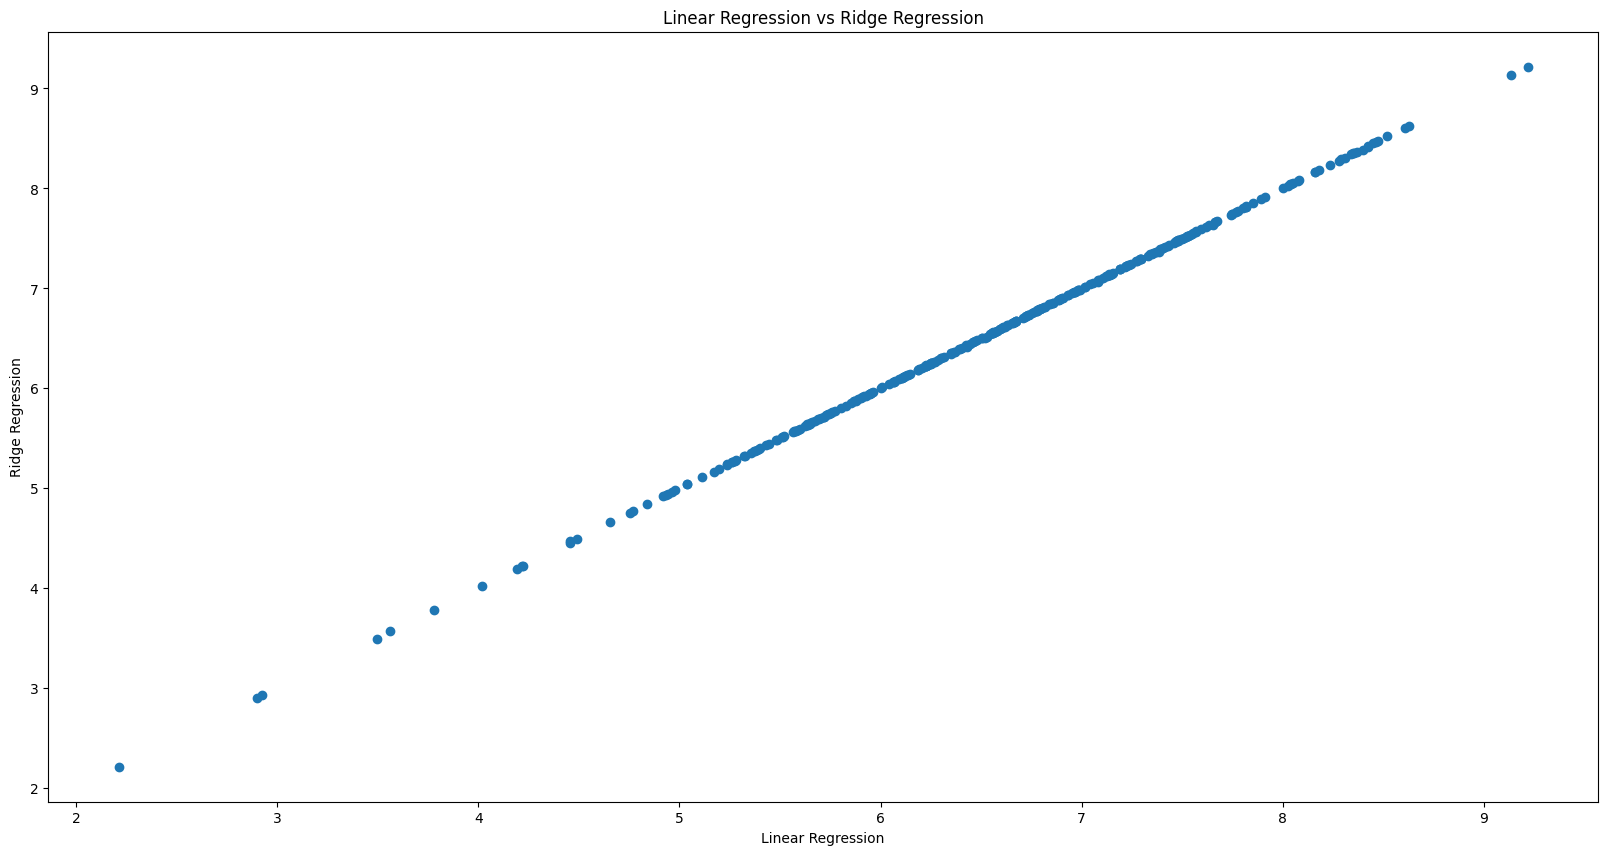

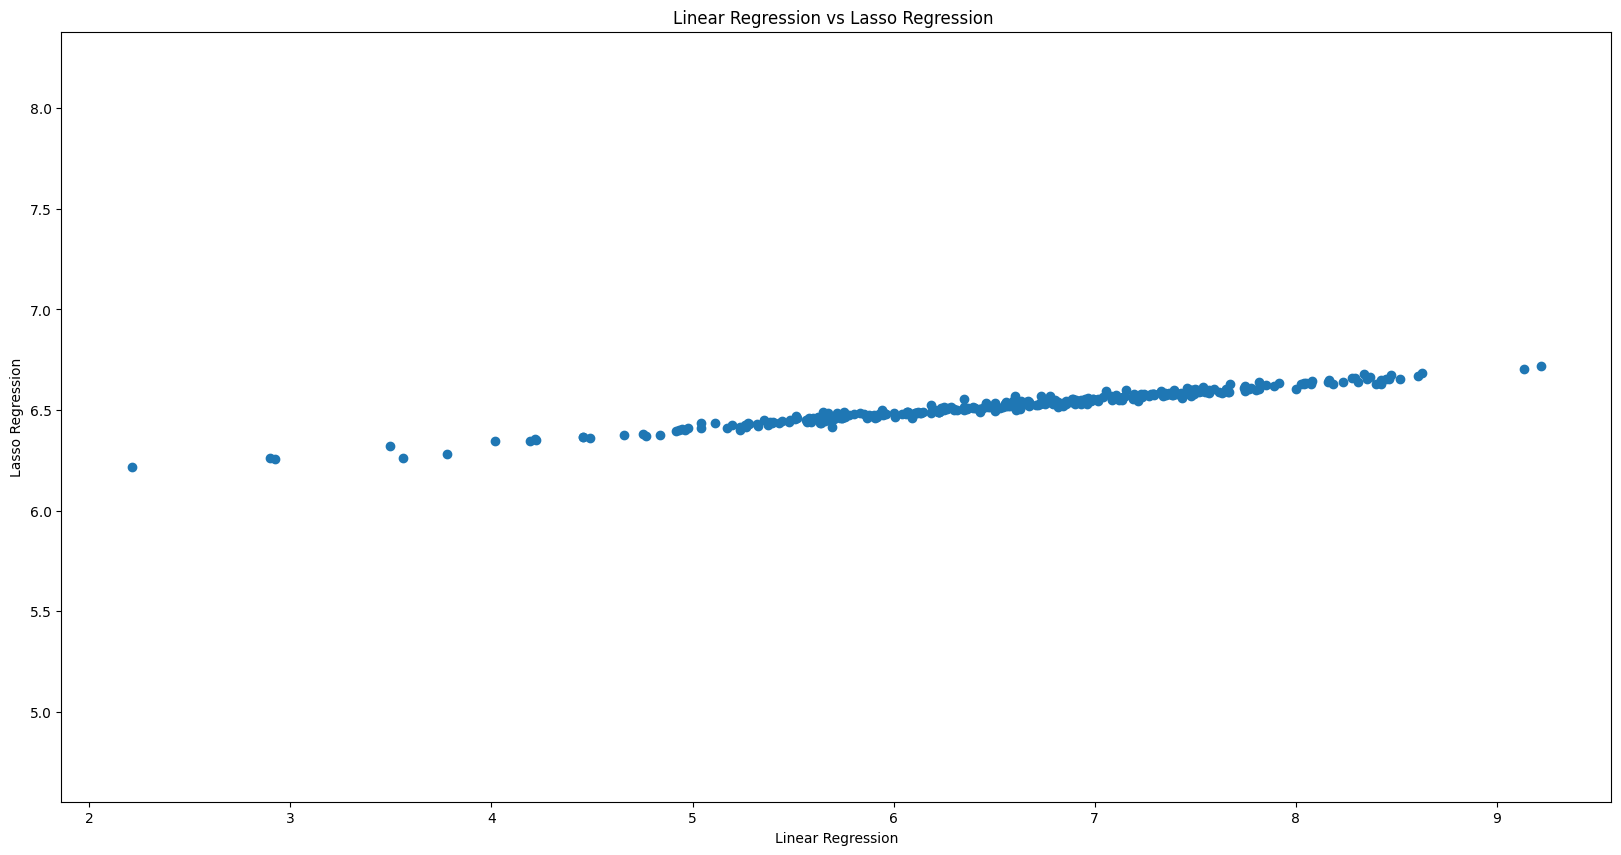

In [37]:
# Demonstrating the difference between LR and Ridge
plt.figure(figsize=(20,10))
plt.scatter(lr_y_predict, Ridge_y_predict)  # y is your actual target values
plt.xlabel("Linear Regression")
plt.ylabel("Ridge Regression")
plt.title("Linear Regression vs Ridge Regression")
plt.show()

# Demonstrating the difference between LR and  
lr_y_predict = lr_model.predict(X_test)  # X is your feature data
plt.figure(figsize=(20,10))
plt.scatter(lr_y_predict, Lasso_y_predict)  # y is your actual target values
plt.xlabel("Linear Regression")
plt.ylabel("Lasso Regression")
plt.axis('equal')
plt.title("Linear Regression vs Lasso Regression ")
plt.show()

## Demonstrating the mean and median of the 3 algorithms

In [38]:
# Getting the mean for all the algorithms
print("Mean Linear Regression: ",lr_y_predict.mean())
print("Mean Ridge Regression: ",Ridge_y_predict.mean())
print("Mean Lasso Regression: ",Lasso_y_predict.mean())

Mean Linear Regression:  6.563973495131255
Mean Ridge Regression:  6.563579820650559
Mean Lasso Regression:  6.522200239438898


In [39]:
# Getting the median for all the algorithms
lrmedian = np.median(lr_y_predict)
Ridgemedian = np.median(Ridge_y_predict)
LassoMedian = np.median(Lasso_y_predict)

print("Linear Regression Median: ",lrmedian)
print("Ridge Regression Median: ",Ridgemedian)
print("Lasso Regression Median: ",LassoMedian)

Linear Regression Median:  6.612733343708582
Ridge Regression Median:  6.613689677898387
Lasso Regression Median:  6.527528471662332


In [40]:
# Creating the final dataframe linking the predicted score with the movie/show
final_df=X_test
final_df['predicted_imdb_score'] = 0
final_df['predicted_imdb_score']=lr_y_predict
final_df = pd.merge(final_df, newMedia, left_index = True,right_index = True)
final_df = final_df.drop(columns=columns_to_exclude)
selected=['title','predicted_imdb_score','imdb_score','cumulative_avg_actor_score','cumulative_avg_director_score']
display_df=final_df[selected]
display_df


,title,predicted_imdb_score,imdb_score,cumulative_avg_actor_score,cumulative_avg_director_score
438,Kevin Hart: I'm a Grown Little Man,8.351926,7.5,5.914286,7.257143
239,Insidious,6.286898,6.8,6.662444,7.025000
300,Dead Set,8.462223,7.6,7.485714,7.600000
361,Mobile Suit Gundam Unicorn,6.842883,7.8,7.467359,7.800000
692,Smile PreCure!,8.183000,6.2,6.538257,6.200000
...,...,...,...,...,...
286,Halloween,7.272288,6.0,6.118284,6.600000
408,First Sunday,6.666994,4.5,5.360464,5.533333
1585,Husband Factor,8.082554,6.2,6.041667,5.900000
1357,Strange Weather,5.274242,6.0,6.088944,6.000000


In [41]:
# Create a DataFrame with performance metrics
data = {
    'Model': ['Linear Regression', 'Ridge Regression', 'Lasso Regression'],
    'MSE': [lr_mse, ridge_mse, lasso_mse],
    'R-squared': [linear_reg_r2, ridge_reg_r2, lasso_reg_r2]
}
performance_df = pd.DataFrame(data)

# Set the 'Model' column as the index
performance_df.set_index('Model', inplace=True)

# Display the performance comparison table
print(performance_df)

                        MSE  R-squared
Model                                 
Linear Regression  0.071323   0.943213
Ridge Regression   0.071426   0.943131
Lasso Regression   1.092558   0.130108
